In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import sklearn.metrics

In [117]:
#I added corresponding headers to each column to facilitate processing
dataframe = pd.read_csv("layton_wildprocessed_1", header = 0)  
# print (dataframe)
dataframe = dataframe.drop("tmp1", axis = 1)
data = dataframe.drop("tmp2", axis = 1)
data = data[500:9000]
# df.plot(x='emg',y = 'x')
# df.head()
assert not np.any(np.isnan(data))

In [119]:
#These are the quantative features we need to normalize (all four dimensional inputs)
quant_features = ['emg']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}

def data_normalization(data):
    for each in quant_features:
        mean, std = data[each].mean(), data[each].std()
        scaled_features[each] = [mean, std]
        data.loc[:, each] = (data[each] - mean)/std
        
data_normalization(data)
# print (data)
print (np.any(np.isnan(data)))

False


In [98]:
#Divide date into testing and training sets
train_data = data

In [99]:
tr_dataframe = pd.read_csv("sam_wildprocessed", header = 0)  
# print (data)
tr_dataframe = tr_dataframe.drop("tmp1", axis = 1)
tr_data = tr_dataframe.drop("tmp2", axis = 1)
test_data = tr_data
# print(test_data)
#These are the quantative features we need to normalize (all four dimensional inputs)
data_normalization(test_data)

In [100]:
target_fields = ['x', 'y', 'z']
features, targets = train_data[:-1], train_data[1:][target_fields]
# print(features, targets)
test_features, test_targets = test_data[:-1], test_data[1:][target_fields]

In [121]:
#divide training data into training and validation sets
train_features, train_targets = features[:-2000], targets[:-2000]
val_features, val_targets = features[-2000:], targets[-2000:]
# print (train_features, train_targets)
assert not np.any(np.isnan(features))

In [122]:
def MSE(y, Y):
#     return (sklearn.metrics.mean_squared_error(y, Y))
    return (np.average(np.subtract(y,Y)**2))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    '''
    relu doesn't really work here....
    '''
    return np.maximum(x, 0)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

class NeuralNetwork(object):
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate, bias):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

#         Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes)) 
#         self.weights_input_to_hidden = np.random.random(
#                                        (self.hidden_nodes, self.input_nodes)) - bias 
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
#         self.weights_hidden_to_output = np.random.random(
#                                        (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # Activation function is the sigmoid function, we could also use lamda notation here

        self.activation_function = sigmoid

    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2, dtype=np.float128).T
        targets = np.array(targets_list, ndmin=2, dtype=np.float128).T
        
        ### Forward pass ###
        # Hidden layer 
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs
        
        ### Backward pass ###
        
        # Output error
        output_errors =  targets - final_outputs
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors)  
        hidden_grad = hidden_outputs * (1 - hidden_outputs) 
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_hidden += self.lr * np.dot((hidden_errors * hidden_grad), inputs.T)   
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2, dtype=np.float128).T
#         print (inputs)
        #### Implementation of the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
#         print (hidden_inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        # Output layer
        final_outputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
#         print (final_outputs)
        return final_outputs

In [136]:
import sys

### Set the hyperparameters here ###
epochs = 100
learning_rate = 0.01
hidden_nodes = 8
output_nodes = 3
bias = 0.001

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate, bias)

losses = {'train':[], 'validation':[], 'test':[]}
# for t in target_fields:
#     print ("Now training for " + str(t))
for e in range(epochs):
    ## Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=64)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch].values):
        network.train(record, target)

    ## Printing out the training progress
#     print (train_targets.values.T)
    train_loss = MSE(network.run(train_features), train_targets.values.T)  
    val_loss = MSE(network.run(val_features), val_targets.values.T)
    test_loss = MSE(network.run(test_features), test_targets.values.T)
#         sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:5] \
#                          + "% ... Training loss: " + str(train_loss)[:6] \
#                          + " ... Validation loss: " + str(val_loss)[:6])

    print ("\rProgress: " + str(100 * e/float(epochs))[:5] \
                     + "% ... Training loss: " + str(train_loss)[:6] \
                     + " ... Validation loss: " + str(val_loss)[:6]\
                     + " ... Test loss: " + str(test_loss)[:6]
          )
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)
    losses['test'].append(test_loss)
#     print (network.weights_input_to_hidden, network.weights_hidden_to_output)

# print (test_loss)

Progress: 0.0% ... Training loss: 0.8006 ... Validation loss: 1.2099 ... Test loss: 0.4210
Progress: 1.0% ... Training loss: 0.6033 ... Validation loss: 0.9417 ... Test loss: 0.3002
Progress: 2.0% ... Training loss: 0.4501 ... Validation loss: 0.7130 ... Test loss: 0.2158
Progress: 3.0% ... Training loss: 0.3187 ... Validation loss: 0.5180 ... Test loss: 0.2017
Progress: 4.0% ... Training loss: 0.2434 ... Validation loss: 0.4067 ... Test loss: 0.2047
Progress: 5.0% ... Training loss: 0.1915 ... Validation loss: 0.3370 ... Test loss: 0.1825
Progress: 6.0% ... Training loss: 0.1505 ... Validation loss: 0.2537 ... Test loss: 0.1871
Progress: 7.0% ... Training loss: 0.1298 ... Validation loss: 0.2202 ... Test loss: 0.1795
Progress: 8.0% ... Training loss: 0.1213 ... Validation loss: 0.2121 ... Test loss: 0.1646
Progress: 9.0% ... Training loss: 0.1164 ... Validation loss: 0.2012 ... Test loss: 0.1620
Progress: 10.0% ... Training loss: 0.1098 ... Validation loss: 0.1867 ... Test loss: 0.188

(-0.034213904858548222, 0.3)

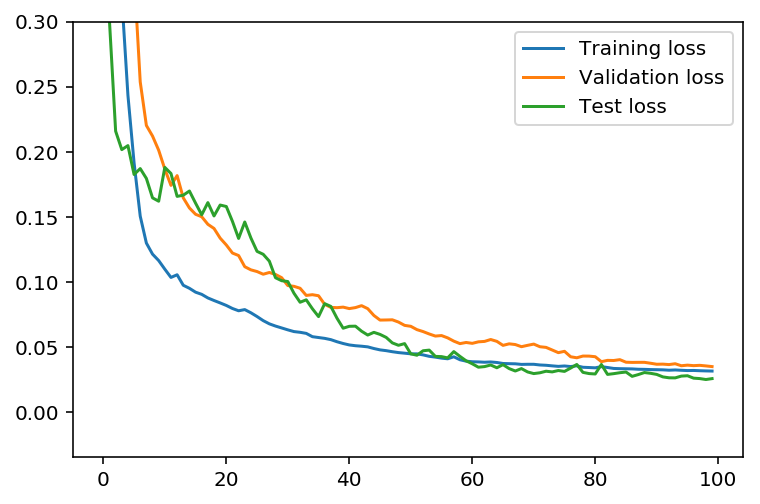

In [137]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.plot(losses['test'], label='Test loss')
plt.legend()
plt.ylim(ymax=0.3)

In [138]:
print (network.weights_input_to_hidden, network.weights_hidden_to_output)
tr_dataframe1 = pd.read_csv("val_wildprocessed", header = 0)  
# print (data)
tr_dataframe1 = tr_dataframe1.drop("tmp1", axis = 1)
tr_data1 = tr_dataframe1.drop("tmp2", axis = 1)
test_data1 = tr_data1
# print(test_data)
#These are the quantative features we need to normalize (all four dimensional inputs)
data_normalization(test_data1)


[[-0.2964402  -1.01763687 -0.54187935  0.7761892 ]
 [ 0.05100697 -0.22790338 -0.46366724  0.63275803]
 [ 0.38197961  0.19424032  0.93860677  0.86387993]
 [ 0.31006952  0.59082783 -0.56626507 -0.05051789]
 [-0.18935916 -0.20890188  0.64626318 -0.30751908]
 [ 0.1583232  -0.3629618  -0.0293073  -0.79848429]
 [ 0.07348727 -0.84757232 -0.6087401   0.03471074]
 [-0.26083696  1.03174857 -0.30102153  0.06530886]] [[-0.73359549  0.24783488  0.12837891  1.05314026 -0.21672764 -1.00180238
  -0.89746122  1.54573602]
 [-0.737953   -0.76356669  1.16155281 -1.08147059  2.07406976  0.26194338
  -0.77264575 -0.25870304]
 [ 1.21166249  0.93266608  1.03538767 -0.42243718 -1.25447217 -1.63813514
  -0.13221548  0.36608575]]


## TODO

* More tests on the results; especially on measuring the errors; (Maybe cross-validation?)